# Inferential Statistics III - Bayesian

### Loading the data and performing an initial view

In [121]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import gamma
# there has been some incompatibilty between theano and numpy, if you encounter
# an error with the latest packages from anaconda, then the included
# package-list-txt should allow you to create a conda environment with compatible
# packages.

In [122]:
medical = pd.read_csv('data/insurance2.csv')

In [123]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [124]:
insurance = medical.charges[medical.insuranceclaim == 1]
no_insurance = medical.charges[medical.insuranceclaim == 0]
n_ins = len(insurance)
n_no_ins = len(no_insurance)

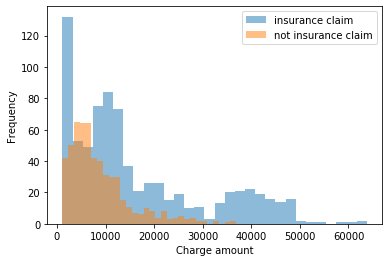

In [125]:
_ = plt.hist(insurance, bins=30, alpha=0.5, label='insurance claim')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='not insurance claim')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

### Initial parameter estimation

In [126]:
alpha_est = np.mean(no_insurance)**2 / np.var(no_insurance)
beta_est = np.var(no_insurance) / np.mean(no_insurance)
alpha_est, beta_est

(1.8759059725250857, 4702.486170152821)

### Initial simulation

In [127]:
seed(47)
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)

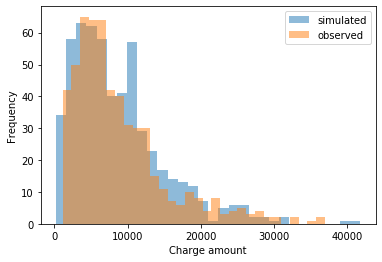

In [128]:
_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

### Creating a PyMC3 model

In [129]:
# PyMC3 Gamma seems to use rate = 1/beta
rate_est = 1/beta_est
# Initial parameter estimates we'll use below
alpha_est, rate_est

(1.8759059725250857, 0.00021265346963636093)

__Q:__ You are now going to create your own PyMC3 model!
1. Use an [exponential](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Exponential) prior for alpha. Call this stochastic variable `alpha_`.
2. Similarly, use an exponential prior for the rate ([$1/\beta$](https://wiki.analytica.com/index.php?title=Gamma_distribution)) parameter in PyMC3's [Gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma). Call this stochastic variable `rate_` (but it will be supplied as `pm.Gamma`'s `beta` parameter). Hint: to set up a prior with an exponential distribution for $x$ where you have an initial estimate for $x$ of $x_0$, use a scale parameter of $1/x_0$.
5. Create your Gamma distribution with your `alpha_` and `rate_` stochastic variables and the observed data.
6. Perform 10000 draws.

Hint: you may find it helpful to work backwards. Start with your `pm.Gamma`, and note the required stochastic variables `alpha` and `beta`. Then, before that, you need to create those stochastic variables using `pm.Exponential` and the correct parameters.

__A:__ Created the PyMC3 model using pm.Exponential on the stochastic variables, alpha and beta. Then, using those variables, created the gamma distribution and run MCMC on them.

In [130]:
with pm.Model() as model:
    alpha_ = pm.Exponential('alpha_', 1/alpha_est)
    rate_ = pm.Exponential('rate_', 1/rate_est)
    no_ins_charge = pm.Gamma('no_ins_charge', alpha=alpha_, beta=rate_, observed=no_insurance)

In [131]:
with model:
    step = pm.Metropolis()
    trace1 = pm.sample(10000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [rate_]
>Metropolis: [alpha_]
Sampling 2 chains: 100%|████████████| 21000/21000 [00:11<00:00, 1768.87draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


If you get a warning about acceptance probability not matching the target, and that it's around 0.88 when it should be close to 0.8, don't worry. We encourage you to read up on this and see if you can adjust the parameters and/or arguments to pm.sample, but if your model runs without any additional warnings or errors then you should be doing great!

__Q:__ Explore your posteriors for $\alpha$ and $\beta$ (from the trace).
* Calculate the 95% credible interval for $\alpha$ and $\beta$.
* Plot your posterior values of $\alpha$ and $\beta$ (both line plots and histograms). 
* Mark your CIs on the histograms.
* Do they look okay? What would bad plots look like?

__A:__  The 95% credible interval for alpha is between 2 and 2.5 with a posterior mean of 2.2.
        The 95% credible interval for beta is between 0.00022 and 0.00028 with a posterior mean of 0.00025.
        The trace plots look good but still show the 'meandering' path. If we run it for longer cycles, we can see the convergence better towards the end. We have iterations for 10000 only in this code. A bad plot would be a straight line.

C:\Users\Ramya\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
C:\Users\Ramya\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Ramya\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020CA9CF3C48>,
      dtype=object)

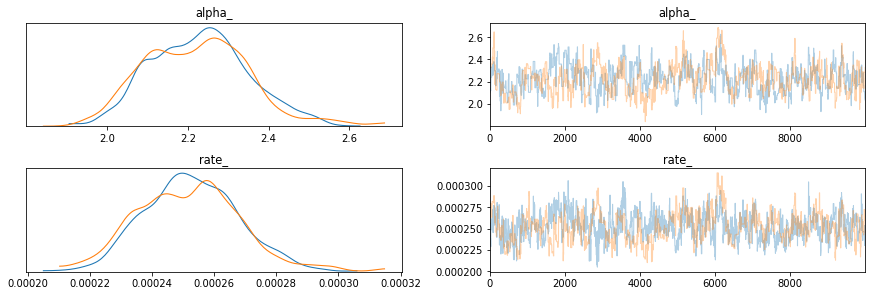

In [134]:
pm.plots.traceplot(data=trace1, varnames=["alpha_", "rate_"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020CA9FAF788>],
      dtype=object)

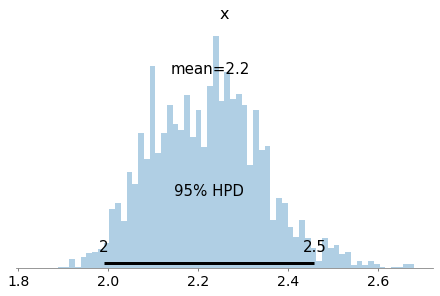

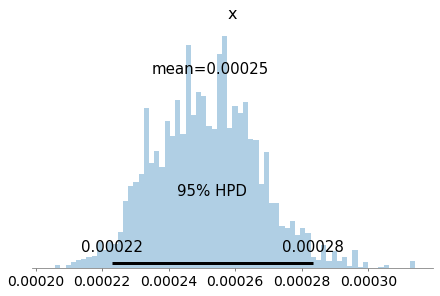

In [135]:
pm.plots.plot_posterior(data=trace1["alpha_"], kind='hist', credible_interval=0.95)
pm.plots.plot_posterior(data=trace1["rate_"], kind='hist', credible_interval=0.95)

__Q:__ Play around with some of the built-in diagnostic plots for your model. We suggest at least checking out the traceplot for alpha and beta. How do they look?

__A:__ I ran the MCMC for 100000 times and selected the last 50000 values to see if the convergence looked better and the mean or 95% credible interval changed. They remain the same.

In [136]:
with model:
    step = pm.Metropolis()
    trace2 = pm.sample(100000, step=step)
 

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [rate_]
>Metropolis: [alpha_]
Sampling 2 chains: 100%|██████████| 201000/201000 [01:45<00:00, 1907.60draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [138]:
burned_trace = trace2[50000:]

C:\Users\Ramya\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
C:\Users\Ramya\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Ramya\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020C8FFFC348>,
      dtype=object)

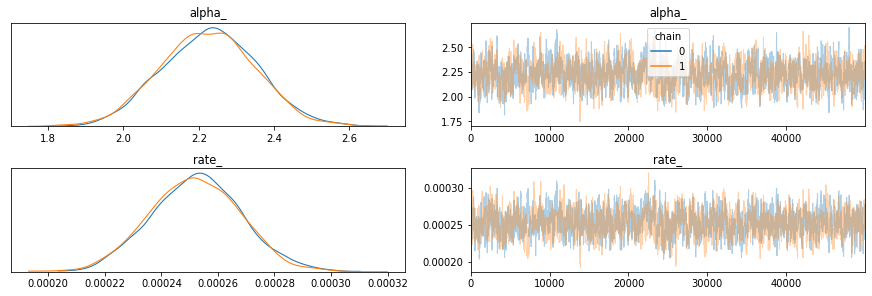

In [139]:
pm.plots.traceplot(data=burned_trace, varnames=["alpha_", "rate_"], legend=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020C95775288>],
      dtype=object)

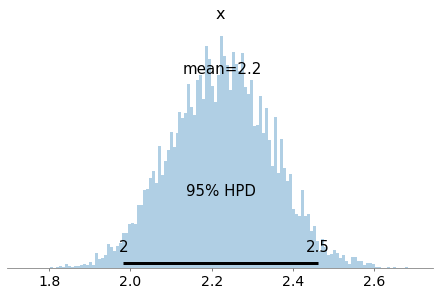

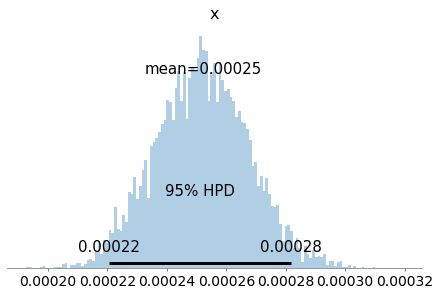

In [140]:
pm.plots.plot_posterior(data=burned_trace["alpha_"], kind='hist', credible_interval=0.95)
pm.plots.plot_posterior(data=burned_trace["rate_"], kind='hist', credible_interval=0.95)

__Q:__ Take your best shot at a new simulated sequence of medical charges using scipy.stat's gamma distribution. Don't forget the difference between functions that take $\beta$ and functions that use $1/\beta$ for the scale parameter. Simulate a data set the same size as the number of observations in the data and overlay the two histograms (simulated and observed).

__A:__ Selected the mean of the alpha and rate variables from the MCMC above, and used to run those parameters on the gamma distribution using scipy.stats.

In [141]:
seed(47)
alpha = np.mean(trace1[alpha_])
rate = np.mean(trace1[rate_])
alpha, rate                    

(2.2269364936745917, 0.00025238683796728313)

In [142]:
seed(47)
best_shot_simulated = gamma(alpha, scale=1/rate).rvs(n_no_ins)

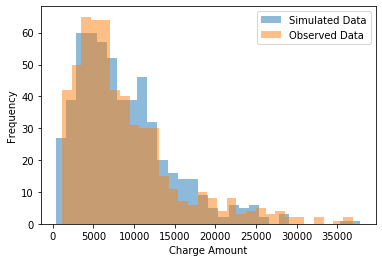

In [143]:
plt.hist(best_shot_simulated, bins=30, alpha=0.5,label='Simulated Data')
plt.hist(no_insurance, bins=30, alpha=0.5,label='Observed Data')
plt.xlabel('Charge Amount')
plt.ylabel('Frequency')
plt.legend()

We can see that the simulated data fits the observed data set very well.

## Summary

In this exercise, we have postulated a distribution to describe the individual charge amounts for non-insured cases. This distribution has two required parameters, which we do not know, but we used PyMC3 to perform Bayesian inference to find our level of "belief" in a range of values for them. We then used the average parameter values to create one simulated data set of the same size as the original, but the distribution of our posteriors for these parameters will allow us to perform simulations of any sample size we desire and for a range of scenarios of different $\alpha$ and $\beta$. This could be a powerful tool to model different financial conditions for the hospital. 

Well done making it through this tricky subject. Starting think Bayesian _and_ starting to get to grips with something like PyMC3 is no easy task. As a data scientist, the most important thing is to be aware that this statistical approach exists, though you may not actually use this approach as much as you use the other approaches you've learned about. Still, we encourage you to think of ways that this approach could apply to the work that you do in this course and throughout your career.  